## [Graph Data Science Python Driver](https://github.com/neo4j/graph-data-science-client)

## Imports

In [36]:
# Data
import pandas as pd
from graphdatascience import GraphDataScience

# Viz
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

## Setup

In [3]:
URI      = "neo4j://localhost:7687"
creds    = ('neo4j', 'password')
gds      = GraphDataScience(URI, auth=creds)

## Load Data
#### Data from https://github.com/CJ2001

### Create Constraint

In [4]:
c = '''
// Create constraints
CREATE CONSTRAINT papers IF NOT EXISTS ON (p:Paper) ASSERT p.id IS UNIQUE;
'''

gds.run_cypher(c)

""


### Import Nodes

In [5]:
c = '''
// Load node list
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/cj2001/pydata2021/main/notebooks/data/cora_nodes.csv' AS line
WITH line
MERGE (p:Paper {id: line.id})
    ON CREATE SET p.subject = line.subject, p.features = line.features
RETURN COUNT(*)
'''

gds.run_cypher(c)

,COUNT(*)
0,2708


### Import Edges

In [6]:
c = '''
// Load edge list
LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/cj2001/pydata2021/main/notebooks/data/cora_edges.csv' AS line
WITH line
MATCH (source:Paper {id: line.source})
MATCH (target:Paper {id: line.target})
MERGE (source)-[:CITES]->(target)
RETURN COUNT(*)
'''

gds.run_cypher(c)

,COUNT(*)
0,5429


## Create graph projection

In [15]:
node_projection = ["Paper"]
relationship_projection = {"CITES": 
                           {"orientation": "UNDIRECTED"}
                          }
# G.drop()

G, _ = gds.graph.project("papers", 
                         node_projection, 
                         relationship_projection)

In [16]:
def projection_stats(G):
    print('name:', G.name(), '\n')
    print('degree_distribution:\n', G.degree_distribution())
    print('density:', G.density(), '\n')
    print('node_count:', G.node_count())
    print('relationship_count:', G.relationship_count())
    
projection_stats(G)

name: papers 

degree_distribution:
 p99      19.000000
min       1.000000
max     169.000000
mean      4.009601
p90       7.000000
p50       3.000000
p999     65.000000
p95       9.000000
p75       5.000000
dtype: float64
density: 0.0014811973334628368 

node_count: 2708
relationship_count: 10858


## Stream FastRP Embeddings

In [17]:
# Run FastRP and mutate projection with result
result = gds.fastRP.stream(
    G,
    embeddingDimension=64,
    iterationWeights=[0.8, 1, 1, 1],
)

result.head()

,nodeId,embedding
0,0,"[0.12731266021728516, -0.5770813226699829, -0...."
1,1,"[0.44332268834114075, -0.0691147893667221, -0...."
2,2,"[0.4104289710521698, -0.07236936688423157, -0...."
3,3,"[-0.0349864587187767, -0.3062233328819275, -0...."
4,4,"[0.0010526117403060198, -0.274589866399765, 0...."


### Clean up Dataframe with Pandas transforms

In [18]:
df = pd.concat([result[['nodeId']],
                   pd.DataFrame.from_dict(dict(zip(result.embedding.index, result.embedding.values))).T],
                axis=1)
df.head()

,nodeId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0,0.127313,-0.577081,-0.839944,0.594380,0.212860,-0.008610,-0.607579,0.231232,0.068191,-0.093008,-0.217910,0.685538,-0.792613,-0.896486,-0.098908,-0.522941,-0.459952,-0.156893,-0.178454,-0.039557,0.057402,0.690073,-0.720899,0.428893,0.010436,0.275926,-0.474586,-0.581647,-0.139212,0.109630,-0.065641,0.047147,-0.257259,-0.134519,-0.302528,-0.052433,-0.244658,-0.770265,0.363849,-0.830693,0.280124,-0.500437,0.490281,-0.471582,-0.664273,0.377090,-0.114990,0.043820,0.523752,0.850578,0.964253,-0.363607,-0.811747,-0.055142,0.262114,0.322975,-0.161358,0.511980,0.427511,-0.448933,0.117483,0.300364,0.552835,0.005076
1,1,0.443323,-0.069115,-0.122442,-0.142836,0.655094,-0.319413,0.062010,-0.079231,-0.841537,-0.244914,0.511177,0.136553,0.173141,0.067010,0.293042,-0.060024,0.073166,0.312561,0.627902,-0.063922,-0.001296,0.052478,-0.505650,-0.331005,0.130288,0.082702,-0.344643,-0.120296,0.345403,-0.049904,0.247605,-0.164401,-0.525125,0.582980,0.318367,-0.142728,-0.739634,-0.449173,-0.202307,0.135491,-0.206580,0.288487,0.122584,-0.032173,0.094134,0.216781,-0.079616,0.169465,0.120075,-0.540228,0.581088,0.618585,-0.045849,-0.669412,-0.353382,-0.361528,0.763695,-0.353492,-0.013365,-0.362078,0.199683,-0.236468,0.021115,-0.025228
2,2,0.410429,-0.072369,-0.524798,0.489786,-0.653215,0.218338,-0.193690,-0.241074,-0.928167,-0.966514,0.321548,0.371392,0.041938,-0.478851,-0.057198,-0.406987,-0.052577,-0.053563,0.296010,-0.198039,0.795613,0.436179,-0.139665,0.004890,-0.688395,0.055851,-0.051534,0.399641,0.042021,0.645098,-0.311243,0.110176,-0.333898,-0.077975,0.327964,-0.513484,-0.357119,-0.064756,-0.583525,0.039959,0.001325,-0.151931,-0.694100,-0.080193,0.016641,0.092359,0.039922,-0.071796,-0.005661,0.493889,-0.387295,-0.363730,-0.631001,-0.381643,0.504607,-0.056943,0.012531,-0.805443,0.441973,0.610990,-0.348369,-0.121898,0.538244,0.108462
3,3,-0.034986,-0.306223,-0.425366,-0.065730,-0.615661,-0.439860,0.028786,0.028571,-0.264813,-0.317538,-0.466165,0.208303,-0.441269,-0.075812,0.112169,-0.271574,-0.245923,0.363588,0.762678,0.486434,0.394431,-0.154701,0.540802,-0.653220,-0.768768,-0.062846,0.175883,-0.111239,-0.182376,0.491062,-0.336042,-0.174280,-0.109818,-0.167208,0.733710,-0.137143,0.065918,0.077417,-0.154251,0.342339,0.023736,0.056507,-0.293492,-0.083332,0.012635,-0.086926,0.092433,-0.540194,-0.288998,0.174839,-0.249548,-0.179969,-0.350848,-0.289717,0.514591,0.115351,0.030799,-0.209966,0.378074,0.061466,-0.089908,-0.105452,0.346067,-0.335874
4,4,0.001053,-0.274590,0.258307,-0.170474,0.022738,0.010215,-0.349967,0.315358,0.621971,-0.784153,0.071355,0.380573,-0.403523,0.519598,0.009604,0.094215,-0.159737,0.057347,-0.237785,-0.117364,-0.288005,0.454683,-0.080987,0.052791,0.576886,0.021976,-0.146834,-0.133580,0.678143,0.390044,0.402250,-0.047566,0.125674,0.114154,0.069815,-0.054112,0.327958,-0.754727,-0.052855,-0.498185,-0.238292,0.255267,0.185842,-0.208449,0.243209,0.374471,0.550487,0.335112,-0.199435,-0.025746,0.222490,0.466057,0.144591,0.236080,-0.039301,-0.014112,-0.082491,-0.008208,0.196844,-0.239928,0.225883,-0.317224,-0.000340,0.261194


In [19]:
df = pd.merge(gds.run_cypher('MATCH (n:Paper) RETURN id(n) as nodeId, n.subject as class'),
                df,
              on="nodeId")
df.head()

,nodeId,class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0,Neural_Networks,0.127313,-0.577081,-0.839944,0.594380,0.212860,-0.008610,-0.607579,0.231232,0.068191,-0.093008,-0.217910,0.685538,-0.792613,-0.896486,-0.098908,-0.522941,-0.459952,-0.156893,-0.178454,-0.039557,0.057402,0.690073,-0.720899,0.428893,0.010436,0.275926,-0.474586,-0.581647,-0.139212,0.109630,-0.065641,0.047147,-0.257259,-0.134519,-0.302528,-0.052433,-0.244658,-0.770265,0.363849,-0.830693,0.280124,-0.500437,0.490281,-0.471582,-0.664273,0.377090,-0.114990,0.043820,0.523752,0.850578,0.964253,-0.363607,-0.811747,-0.055142,0.262114,0.322975,-0.161358,0.511980,0.427511,-0.448933,0.117483,0.300364,0.552835,0.005076
1,1,Rule_Learning,0.443323,-0.069115,-0.122442,-0.142836,0.655094,-0.319413,0.062010,-0.079231,-0.841537,-0.244914,0.511177,0.136553,0.173141,0.067010,0.293042,-0.060024,0.073166,0.312561,0.627902,-0.063922,-0.001296,0.052478,-0.505650,-0.331005,0.130288,0.082702,-0.344643,-0.120296,0.345403,-0.049904,0.247605,-0.164401,-0.525125,0.582980,0.318367,-0.142728,-0.739634,-0.449173,-0.202307,0.135491,-0.206580,0.288487,0.122584,-0.032173,0.094134,0.216781,-0.079616,0.169465,0.120075,-0.540228,0.581088,0.618585,-0.045849,-0.669412,-0.353382,-0.361528,0.763695,-0.353492,-0.013365,-0.362078,0.199683,-0.236468,0.021115,-0.025228
2,2,Reinforcement_Learning,0.410429,-0.072369,-0.524798,0.489786,-0.653215,0.218338,-0.193690,-0.241074,-0.928167,-0.966514,0.321548,0.371392,0.041938,-0.478851,-0.057198,-0.406987,-0.052577,-0.053563,0.296010,-0.198039,0.795613,0.436179,-0.139665,0.004890,-0.688395,0.055851,-0.051534,0.399641,0.042021,0.645098,-0.311243,0.110176,-0.333898,-0.077975,0.327964,-0.513484,-0.357119,-0.064756,-0.583525,0.039959,0.001325,-0.151931,-0.694100,-0.080193,0.016641,0.092359,0.039922,-0.071796,-0.005661,0.493889,-0.387295,-0.363730,-0.631001,-0.381643,0.504607,-0.056943,0.012531,-0.805443,0.441973,0.610990,-0.348369,-0.121898,0.538244,0.108462
3,3,Reinforcement_Learning,-0.034986,-0.306223,-0.425366,-0.065730,-0.615661,-0.439860,0.028786,0.028571,-0.264813,-0.317538,-0.466165,0.208303,-0.441269,-0.075812,0.112169,-0.271574,-0.245923,0.363588,0.762678,0.486434,0.394431,-0.154701,0.540802,-0.653220,-0.768768,-0.062846,0.175883,-0.111239,-0.182376,0.491062,-0.336042,-0.174280,-0.109818,-0.167208,0.733710,-0.137143,0.065918,0.077417,-0.154251,0.342339,0.023736,0.056507,-0.293492,-0.083332,0.012635,-0.086926,0.092433,-0.540194,-0.288998,0.174839,-0.249548,-0.179969,-0.350848,-0.289717,0.514591,0.115351,0.030799,-0.209966,0.378074,0.061466,-0.089908,-0.105452,0.346067,-0.335874
4,4,Probabilistic_Methods,0.001053,-0.274590,0.258307,-0.170474,0.022738,0.010215,-0.349967,0.315358,0.621971,-0.784153,0.071355,0.380573,-0.403523,0.519598,0.009604,0.094215,-0.159737,0.057347,-0.237785,-0.117364,-0.288005,0.454683,-0.080987,0.052791,0.576886,0.021976,-0.146834,-0.133580,0.678143,0.390044,0.402250,-0.047566,0.125674,0.114154,0.069815,-0.054112,0.327958,-0.754727,-0.052855,-0.498185,-0.238292,0.255267,0.185842,-0.208449,0.243209,0.374471,0.550487,0.335112,-0.199435,-0.025746,0.222490,0.466057,0.144591,0.236080,-0.039301,-0.014112,-0.082491,-0.008208,0.196844,-0.239928,0.225883,-0.317224,-0.000340,0.261194


## Loop over desired algorithms and add them to Dataframe

In [20]:
for algo in ['pageRank', 'betweenness']:
    method = getattr(gds, algo)
    
    df = pd.merge(df, 
                    method.stream(G).rename(columns={'score': algo}),
                  on="nodeId")
df.head()

,nodeId,class,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,pageRank,betweenness
0,0,Neural_Networks,0.127313,-0.577081,-0.839944,0.594380,0.212860,-0.008610,-0.607579,0.231232,0.068191,-0.093008,-0.217910,0.685538,-0.792613,-0.896486,-0.098908,-0.522941,-0.459952,-0.156893,-0.178454,-0.039557,0.057402,0.690073,-0.720899,0.428893,0.010436,0.275926,-0.474586,-0.581647,-0.139212,0.109630,-0.065641,0.047147,-0.257259,-0.134519,-0.302528,-0.052433,-0.244658,-0.770265,0.363849,-0.830693,0.280124,-0.500437,0.490281,-0.471582,-0.664273,0.377090,-0.114990,0.043820,0.523752,0.850578,0.964253,-0.363607,-0.811747,-0.055142,0.262114,0.322975,-0.161358,0.511980,0.427511,-0.448933,0.117483,0.300364,0.552835,0.005076,0.971196,0.500000
1,1,Rule_Learning,0.443323,-0.069115,-0.122442,-0.142836,0.655094,-0.319413,0.062010,-0.079231,-0.841537,-0.244914,0.511177,0.136553,0.173141,0.067010,0.293042,-0.060024,0.073166,0.312561,0.627902,-0.063922,-0.001296,0.052478,-0.505650,-0.331005,0.130288,0.082702,-0.344643,-0.120296,0.345403,-0.049904,0.247605,-0.164401,-0.525125,0.582980,0.318367,-0.142728,-0.739634,-0.449173,-0.202307,0.135491,-0.206580,0.288487,0.122584,-0.032173,0.094134,0.216781,-0.079616,0.169465,0.120075,-0.540228,0.581088,0.618585,-0.045849,-0.669412,-0.353382,-0.361528,0.763695,-0.353492,-0.013365,-0.362078,0.199683,-0.236468,0.021115,-0.025228,0.318668,0.000000
2,2,Reinforcement_Learning,0.410429,-0.072369,-0.524798,0.489786,-0.653215,0.218338,-0.193690,-0.241074,-0.928167,-0.966514,0.321548,0.371392,0.041938,-0.478851,-0.057198,-0.406987,-0.052577,-0.053563,0.296010,-0.198039,0.795613,0.436179,-0.139665,0.004890,-0.688395,0.055851,-0.051534,0.399641,0.042021,0.645098,-0.311243,0.110176,-0.333898,-0.077975,0.327964,-0.513484,-0.357119,-0.064756,-0.583525,0.039959,0.001325,-0.151931,-0.694100,-0.080193,0.016641,0.092359,0.039922,-0.071796,-0.005661,0.493889,-0.387295,-0.363730,-0.631001,-0.381643,0.504607,-0.056943,0.012531,-0.805443,0.441973,0.610990,-0.348369,-0.121898,0.538244,0.108462,0.749227,742.050666
3,3,Reinforcement_Learning,-0.034986,-0.306223,-0.425366,-0.065730,-0.615661,-0.439860,0.028786,0.028571,-0.264813,-0.317538,-0.466165,0.208303,-0.441269,-0.075812,0.112169,-0.271574,-0.245923,0.363588,0.762678,0.486434,0.394431,-0.154701,0.540802,-0.653220,-0.768768,-0.062846,0.175883,-0.111239,-0.182376,0.491062,-0.336042,-0.174280,-0.109818,-0.167208,0.733710,-0.137143,0.065918,0.077417,-0.154251,0.342339,0.023736,0.056507,-0.293492,-0.083332,0.012635,-0.086926,0.092433,-0.540194,-0.288998,0.174839,-0.249548,-0.179969,-0.350848,-0.289717,0.514591,0.115351,0.030799,-0.209966,0.378074,0.061466,-0.089908,-0.105452,0.346067,-0.335874,0.632337,101.481038
4,4,Probabilistic_Methods,0.001053,-0.274590,0.258307,-0.170474,0.022738,0.010215,-0.349967,0.315358,0.621971,-0.784153,0.071355,0.380573,-0.403523,0.519598,0.009604,0.094215,-0.159737,0.057347,-0.237785,-0.117364,-0.288005,0.454683,-0.080987,0.052791,0.576886,0.021976,-0.146834,-0.133580,0.678143,0.390044,0.402250,-0.047566,0.125674,0.114154,0.069815,-0.054112,0.327958,-0.754727,-0.052855,-0.498185,-0.238292,0.255267,0.185842,-0.208449,0.243209,0.374471,0.550487,0.335112,-0.199435,-0.025746,0.222490,0.466057,0.144591,0.236080,-0.039301,-0.014112,-0.082491,-0.008208,0.196844,-0.239928,0.225883,-0.317224,-0.000340,0.261194,0.442147,0.000000


## Create Pandas Plot

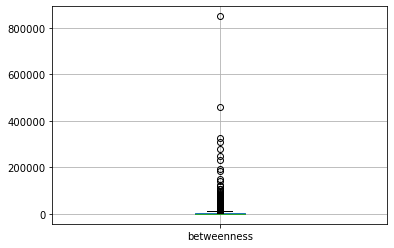

In [21]:
boxplot = df.boxplot(column=['betweenness'])  

## Create Seaborn Plot

<AxesSubplot:xlabel='pageRank', ylabel='Count'>

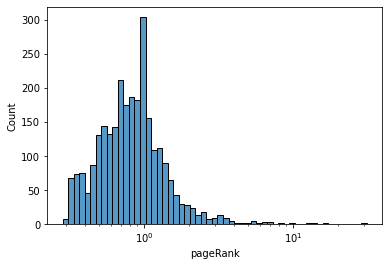

In [22]:
sns.histplot(df.pageRank, log_scale=True)

## Visualize FastRP embeddings with TSNE plot

In [23]:
def create_tsne_plot(df):

    X_emb = TSNE(n_components=2).fit_transform(df[df.columns[2:-3]])

    tsne_df = pd.DataFrame(data = {
        'x': [value[0] for value in X_emb],
        'y': [value[1] for value in X_emb], 
        'label': pd.factorize(df['class'])[0].astype("float32")
    })

    plt.figure(figsize=(16,10))
    s = 30
    ax = sns.scatterplot(
        x='x', y='y',
        palette=sns.color_palette('hls', 7),
        data=tsne_df,
        hue='label',
        legend=True, 
        s=100,
        alpha=0.75
    )
    ax.legend(prop={'size': 10})
    plt.xlabel('X Component', fontsize=16)
    plt.ylabel('Y Component', fontsize=16)
    plt.show

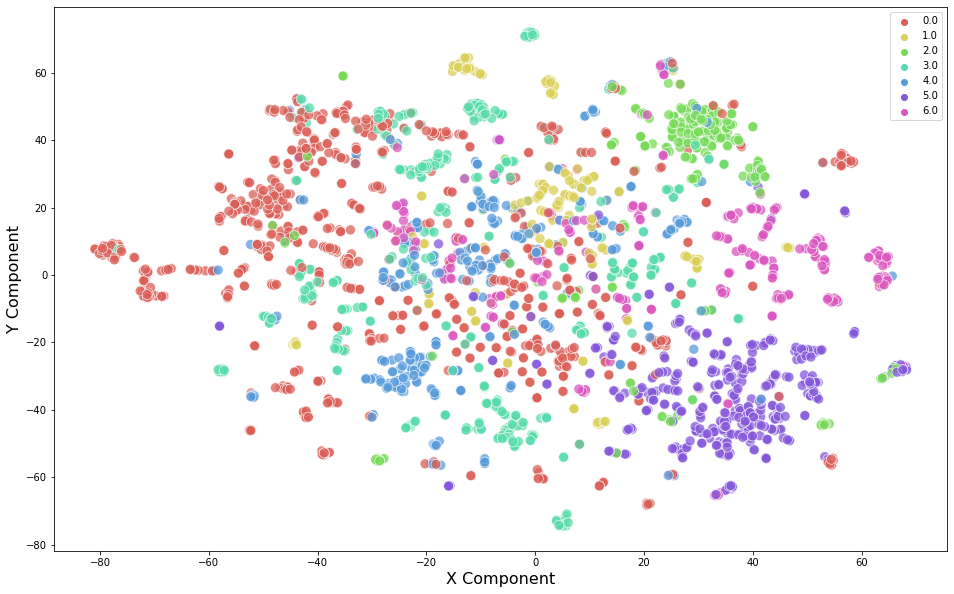

In [24]:
create_tsne_plot(df)

## Split Train & Test Data

In [25]:
encoder = LabelEncoder()
encoder.fit(df['class'])

df['class'] = encoder.transform(df['class'])


In [26]:
X = df[df.columns[2:-3]]  # Features
y = df['class']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

## Build Classifier

In [32]:
#Create a Gaussian Classifier
clf = XGBClassifier(n_estimators=100,
                    use_label_encoder=False,
                    eval_metric='mlogloss')

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

## Classifier Metrics

In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8228782287822878


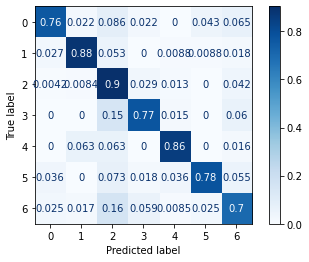

In [34]:
matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.show(matrix)
plt.show()

<AxesSubplot:title={'center':'Top 20 Feature Importances'}, ylabel='Feature'>

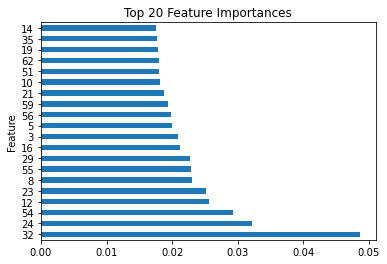

In [35]:
top_n = 20

feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(top_n).plot(kind='barh', 
                                      title=f'Top {top_n} Feature Importances',
                                      xlabel= 'Feature',
                                      ylabel= 'Feature')